In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime
import seaborn as sns
import pickle
%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import data_split
from stock_env import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,trx_plot
from feature_engineer import FeatureEngineer
from models import DRLAgent
from portfolio_optimization_env import PortfolioOptimizationEnv
from pprint import pprint
import scienceplots
import sys
sys.path.append("../FinRL-Library")
import quantstats as qs
plt.style.use('science')
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])
from pandas import read_csv
df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')

In [3]:
TRAIN_START_DATE = '1990-01-01'
TRAIN_END_DATE = '2006-12-30'
TEST_START_DATE = '2007-01-01'
TEST_END_DATE = '2008-12-30'
df_dow = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (128248, 8)


In [9]:
TRAIN_START_DATE = '1991-01-01'


In [4]:
INDICATORS = [
    "close_5_ema",
    "close_5_kama",
    
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df_dow)
processed_dax = processed_dax.copy()
processed_dax = processed_dax.fillna(0)
processed_dax = processed_dax.replace(np.inf,0)
train_data = data_split(processed_dax, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed_dax, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data.tic.unique())
print(f"Stock Dimension: {stock_dimension}")

Successfully added technical indicators
Successfully added turbulence index
Successfully added user defined features
Stock Dimension: 25


In [5]:
train_data.head(50)

,date,open,high,low,close,volume,tic,day,close_5_ema,close_5_kama,turbulence,return
0,1990-01-02,0.314732,0.334821,0.312500,0.262129,183198400,AAPL,1,0.262129,0.262129,0.0,0.006711
0,1990-01-02,1.026042,1.072917,1.005208,0.754523,19267200,AMGN,1,0.754523,0.754523,0.0,0.006711
0,1990-01-02,8.915386,9.011943,8.851015,4.953167,4301237,AXP,1,4.953167,4.953167,0.0,0.006711
0,1990-01-02,19.791668,20.500000,19.666668,11.043627,2042400,BA,1,11.043627,11.043627,0.0,0.006711
0,1990-01-02,7.234375,7.359375,7.218750,3.208574,2910400,CAT,1,3.208574,3.208574,0.0,0.006711
0,1990-01-02,16.843750,17.312500,16.812500,4.690283,2678400,CVX,1,4.690283,4.690283,0.0,0.006711
0,1990-01-02,9.207333,9.515615,9.207333,6.913751,6983477,DIS,1,6.913751,6.913751,0.0,0.006711
0,1990-01-02,1.814815,1.864198,1.796296,1.081852,6206625,HD,1,1.081852,1.081852,0.0,0.006711
0,1990-01-02,8.341983,8.431362,8.282398,3.829831,1538963,HON,1,3.829831,3.829831,0.0,0.006711
0,1990-01-02,22.645794,23.452438,22.586042,9.781486,7365514,IBM,1,9.781486,9.781486,0.0,0.006711


In [51]:
result = benchmark(train_data,test_data,processed_dax,14000,1,['close','return'],INDICATORS,TEST_START_DATE,TEST_END_DATE)

TypeError: benchmark() takes 5 positional arguments but 9 were given

In [4]:
from utils import baseline


result_mvo = baseline(processed_dax,INDICATORS,TEST_START_DATE,TEST_END_DATE)

begin_total_asset:1000000
end_total_asset:1468978.6344728395
Sharpe:  0.5786892595237824
Test Finished!
episode_return 1.4689786344728395
begin_total_asset:1000000
end_total_asset:1204838.789844398
Sharpe:  0.31225039976830304
Test Finished!
episode_return 1.204838789844398
begin_total_asset:1000000
end_total_asset:1204838.789844398
Sharpe:  0.31225039976830304
Test Finished!
episode_return 1.204838789844398


In [36]:
dji = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = ['^dji']).fetch_data()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (2261, 8)


In [6]:
from utils import benchmark

result2 = benchmark(train_data,test_data,50_000,1,['close','return','close_5_kama'])

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./data/tb\ppo_45
------------------------------------
| time/              |             |
|    fps             | 51          |
|    iterations      | 1           |
|    time_elapsed    | 39          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.008399989 |
------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 52            |
|    iterations           | 2             |
|    time_elapsed         | 78            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.013941076   |
|    clip_fraction        | 0.171         |
|    clip_range           | 0.2           |
|    entropy_loss       

In [7]:
from utils import benchmark


result = benchmark(train_data,test_data,50_000,1,['close','return'])

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 128}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./data/tb\ppo_46
-------------------------------------
| time/              |              |
|    fps             | 56           |
|    iterations      | 1            |
|    time_elapsed    | 36           |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | 0.0071289926 |
-------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 56            |
|    iterations           | 2             |
|    time_elapsed         | 72            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.0067542195  |
|    clip_fraction        | 0.0255        |
|    clip_range           | 0.2           |
|    entropy_lo

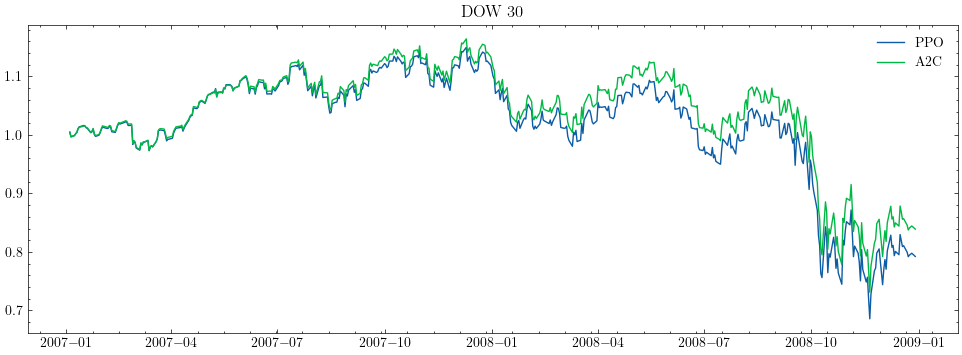

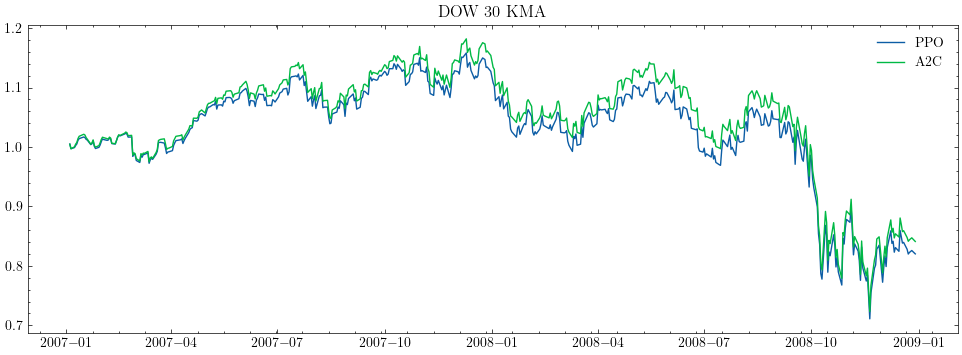

In [12]:
%matplotlib inline

with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4))
    for i,item in enumerate(result): 
            plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod(),label=str(item['name']).upper())
    plt.legend()
    plt.title('DOW 30')
    plt.show()
with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4))
    for i,item in enumerate(result2): 
            plt.plot(item['test'][0].get('date'),(item['test'][0].get('account').pct_change()+ 1 ).cumprod(),label=str(item['name']).upper())
    plt.legend()
    plt.title('DOW 30 KMA')
    plt.show()
